# Churn Analysis

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp

In [2]:
%matplotlib inline 

from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import seaborn as sns
import scipy as sp

# Custom Python Files
from dataprep.dataPrep import cleanData
from dataprep.modelPrep import model_prep
from dataprep.modelPrep import plotROCCurve

## Dataset 



In [3]:
#df = pd.read_csv('../input/mytest.csv')
df = cleanData("PSCCustomerData.csv")

print (df.shape)

df.dtypes

(242, 24)


pageviews                   float64
admins                      float64
employees                   float64
usecompetitors                int64
contractdays                float64
callcycle                    object
associateddeals             float64
timescontacted              float64
origsource                   object
sessions                    float64
FF                            int64
assoccontacts               float64
renewalDT                    object
associatedpredictionlead      int64
industry                     object
publiclytraded              float64
strategic                     int64
MRR                         float64
callcycle_numeric             int64
competingProducts             int64
churn                         int64
daysAsCustomer                int32
callsPerQuarter             float64
sessionsPerDay              float64
dtype: object

In [28]:
df.query("callsPerQuarter > 0 ")

,pageviews,admins,employees,usecompetitors,contractdays,callcycle,associateddeals,timescontacted,origsource,sessions,...,industry,publiclytraded,strategic,MRR,callcycle_numeric,competingProducts,churn,daysAsCustomer,callsPerQuarter,sessionsPerDay
0,0.0,0.0,500.0,0,0.0,Yearly,0.0,7.0,Offline Sources,0.0,...,Construction,0.0,0,1216.00,1,0,1,924,0.691288,0.000000
8,0.0,0.0,1000.0,0,0.0,Yearly,0.0,50.0,Offline Sources,0.0,...,Construction,0.0,0,1216.00,1,0,1,924,4.937771,0.000000
9,0.0,0.0,2600.0,0,0.0,Quarterly,0.0,6.0,Offline Sources,0.0,...,Business Supplies and Equipment,0.0,1,1970.00,4,0,0,779,0.702824,0.000000
10,0.0,0.0,5000.0,0,0.0,Quarterly,3.0,16.0,Offline Sources,0.0,...,Unknown,0.0,0,1666.66,4,0,1,1030,1.417476,0.000000
11,0.0,0.0,2600.0,1,0.0,Quarterly,1.0,30.0,Offline Sources,1.0,...,Unknown,0.0,1,100.00,4,1,0,1029,2.660350,0.000972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.0,0.0,200.0,0,0.0,Half Year,2.0,4.0,Offline Sources,0.0,...,Electrical/Electronic Manufacturing,0.0,0,1760.00,2,0,0,386,0.945596,0.000000
238,5.0,0.0,10000.0,0,0.0,Quarterly,0.0,13.0,Direct Traffic,2.0,...,Consumer Goods,1.0,1,1216.00,4,0,0,352,3.370028,0.005682
239,24.0,0.0,50.0,0,0.0,Yearly,2.0,4.0,Organic Search,8.0,...,Construction,0.0,0,100.00,1,0,0,685,0.532847,0.011679
240,10.0,0.0,200.0,0,0.0,Monthly,8.0,7.0,Organic Search,4.0,...,Construction,0.0,0,1216.00,12,0,1,567,1.126543,0.007055


In [12]:
# Review BoxCox transforms where appropriate
bc_data, value = sp.stats.boxcox(df["callcycle_numeric"])

print(value)

-1.4080563451363535


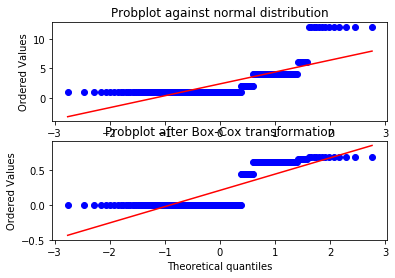

In [8]:
df["callcycle_numeric"] = df["callcycle_numeric"].replace(0,0.01)

fig = plt.figure()
ax1 = fig.add_subplot(211)
x = df["callcycle_numeric"]
prob = sp.stats.probplot(x, dist=sp.stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = sp.stats.boxcox(x)
prob = sp.stats.probplot(xt, dist=sp.stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')

plt.show()

(array([215.,  12.,   6.,   2.,   2.,   3.,   1.,   0.,   0.,   1.]),
 array([0.        , 0.07623591, 0.15247181, 0.22870772, 0.30494363,
        0.38117953, 0.45741544, 0.53365134, 0.60988725, 0.68612316,
        0.76235906]),
 <a list of 10 Patch objects>)

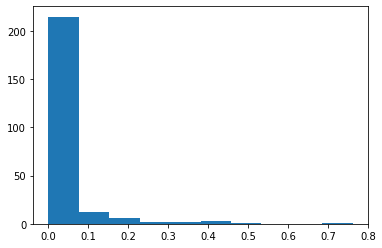

In [18]:
y = df["sessionsPerDay"]
#print (y)

plt.hist(y, bins=10)

In [20]:
df.query("sessionsPerDay > 0.0885")['churn']

40     0
46     0
47     0
63     0
67     0
88     0
89     0
95     0
119    0
137    0
147    0
149    0
153    0
155    0
157    0
158    0
159    0
161    0
163    0
164    0
166    0
187    0
190    0
199    0
202    0
217    0
Name: churn, dtype: int64

In [5]:
y_True = df["churn"][df["churn"] == True]
print ("Churn Percentage = "+str( (y_True.shape[0] / df["churn"].shape[0]) * 100 ))

Churn Percentage = 19.834710743801654


### Conclusion 1 = Imbalanced data - Lesser datapoints in True Churn category

# Descriptive Analysis

In [7]:
df.describe()

,churn,pageviews,admins,employees,usecompetitors,contractdays,associateddeals,timescontacted,sessions,FF,strategic
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,0.198347,71.194215,7.690083,2127.024793,0.206612,1.760331,2.107438,26.433884,34.082645,0.471074,0.194215
std,0.399581,199.306306,47.757242,3517.436949,0.405713,5.423209,2.298481,47.863197,98.411625,0.500197,0.396415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,500.000000,0.000000,0.000000,2.000000,18.000000,1.000000,0.000000,0.000000
75%,0.000000,36.000000,1.000000,1000.000000,0.000000,2.000000,3.000000,32.000000,13.000000,1.000000,0.000000
max,1.000000,1807.000000,600.000000,10000.000000,1.000000,68.000000,21.000000,666.000000,879.000000,1.000000,1.000000


### Churn By Gauge

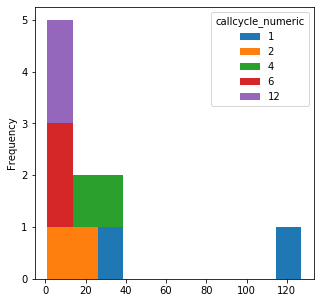

In [12]:
df.groupby(["callcycle_numeric",]"churn").size().unstack().plot(kind='hist', stacked=True, figsize=(5,5)) 

# Look into how we can vview this relationship

### Churn By Call Cycle

### Churn By Industry

In [5]:
df["associateddeals"] = df["associateddeals"].replace(0,0.01)**(1/2)

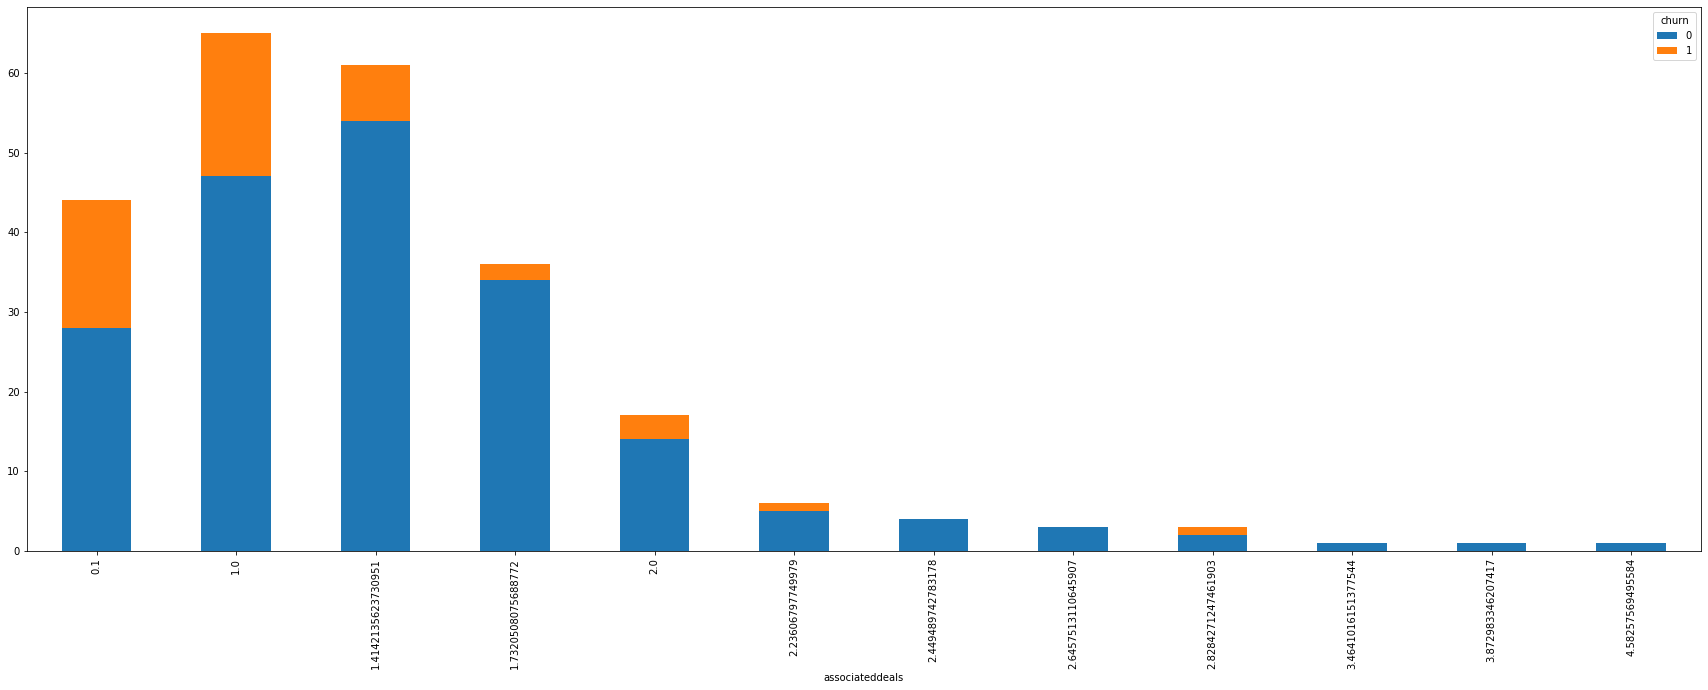

In [6]:
df.groupby(["associateddeals", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)) 

### Churn By Strategic

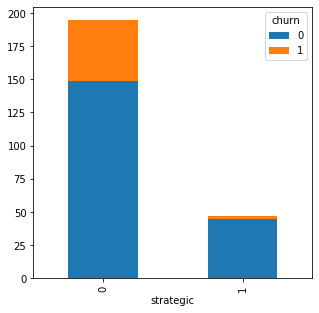

In [10]:
df.groupby(["strategic", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

### Churn By Competitors

In [4]:
# Breakout Competitors
competitors = pd.read_csv('data.csv').query("competingProducts == competingProducts")
competitors.loc[:,('competingProducts')] = competitors.loc[:,('competingProducts')].str.split(pat=";")

namesComps = competitors.explode("competingProducts")

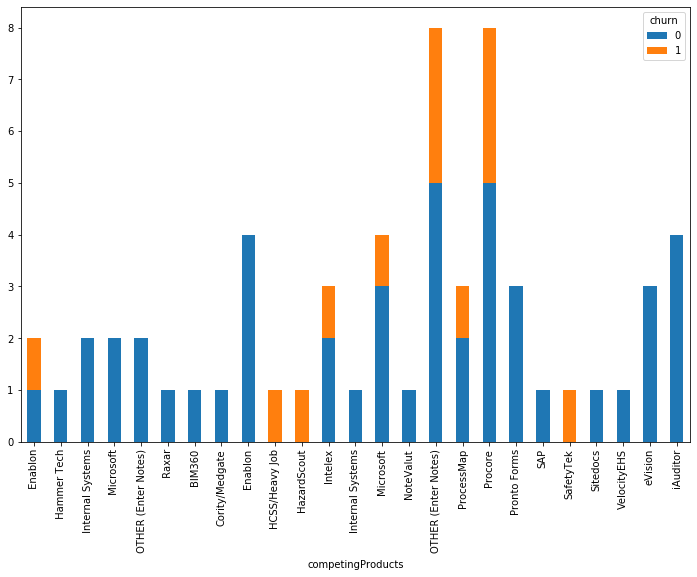

In [6]:
namesComps.groupby(["competingProducts", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,8)) 